In [5]:
import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap
from models import HD_cell_L1, PC_cell_L2

#for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
import pycircstat.descriptive as cd

from data_utils import (
    load_pos_mat, 
    compute_smoothed_speed, 
    compute_smoothed_movement_direction, 
)

from data_analysis_utils import (
    active_scanning_behavioural, 
)
from plotting_utils import (
    plot_circular_histogram,
    plot_expected_theta_sweep,  
    plot_circular_histogram_with_values, 
    plot_paired_boxplot, 
    hexagon_vertices_and_plot, 
)
from CircularLinearReg.core import (
    circular_mean_resultant_vector_length, 
)
from scipy.signal import find_peaks

import os

import pickle

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def simulate_honeycomb_movement(
    total_time=1, 
    dt=0.01, 
    move_prob=0.95, 
    drift_factor=0.0, 
    velocity=0.5, 
    rotation_speed=np.pi / 50,
    stick_length=0.2,
    goal_loc=[0, 0]
):
    
    env_size = 1.0
    time_steps = int(total_time / dt)

    pos_A = np.array([env_size / 2, env_size / 2])
    angle = 0
    pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])
    move_angle = np.random.uniform(-np.pi, np.pi)

    A_trajectory = []   
    B_trajectory = []
    head_directions = []
    rotation_phases = []
    rotation_direction_log = []
    time_list = []
    breakTimepoints = []  # Initialise list


    step_count = 0
    current_time = 0
    just_rotated = False  # New flag to prevent back-to-back rotations

    while step_count < time_steps:
        if (np.random.rand() < move_prob and not just_rotated) or just_rotated:
            
            move_angle = (drift_factor * move_angle) + ((1 - drift_factor) * np.random.uniform(-np.pi, np.pi))
            step_size = velocity * dt
            new_pos_A = pos_A + step_size * np.array([np.cos(move_angle), np.sin(move_angle)])
            new_pos_A = np.clip(new_pos_A, 0, env_size)
            pos_A = new_pos_A
            pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

            A_trajectory.append(pos_A.copy())
            B_trajectory.append(pos_B.copy())
            head_directions.append(angle)
            rotation_phases.append(False)
            rotation_direction_log.append(0)
            time_list.append(current_time)

            step_count += 1
            current_time += dt
            just_rotated = False  # Reset flag after movement
        else:
            # Randomly choose rotation direction: +1 (CW) or -1 (CCW)
            direction_flag = np.random.choice([1, -1])
            rotation_duration = int(np.random.uniform(0.3, 1.0) / dt)

            for _ in range(min(rotation_duration, time_steps - step_count)):
                angle -= direction_flag * rotation_speed  # CW = -rotation
                angle = (angle + np.pi) % (2 * np.pi) - np.pi
                pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

                # Check alignment with goal direction
                vec_to_goal = goal_loc - pos_A
                dir_to_goal = np.arctan2(vec_to_goal[1], vec_to_goal[0])
                angle_diff = ((angle - dir_to_goal + np.pi) % (2 * np.pi)) - np.pi  # Wrap to [-π, π]

                # if np.abs(angle_diff) < np.deg2rad(10):  # e.g. 5° threshold
                #     breakTimepoints.append(current_time)  # Record the time when aligned
                #     break  # Stop rotation if aligned

                # if (np.abs(angle_diff) > np.deg2rad(170)):
                #     breakTimepoints.append(current_time)  # Record the time when aligned
                #     break  # Stop rotation if aligned

                A_trajectory.append((pos_A.copy()+pos_B.copy())/2)
                B_trajectory.append(pos_B.copy())
                head_directions.append(angle)
                rotation_phases.append(True)
                rotation_direction_log.append(direction_flag)
                time_list.append(current_time)

                step_count += 1
                current_time += dt
                if step_count >= time_steps:
                    break
                
            just_rotated = True  # Mark that a rotation just occurred

    A_trajectory = np.array(A_trajectory)
    B_trajectory = np.array(B_trajectory)
    head_directions = np.array(head_directions)
    rotation_phases = np.array(rotation_phases)
    rotation_direction_log = np.array(rotation_direction_log)
    time_original = np.array(time_list)

    displacement = np.linalg.norm(np.diff(B_trajectory, axis=0), axis=1)
    speeds = np.concatenate(([0], displacement / dt))

    dt_new = 0.001
    time_upsampled = np.arange(0, time_original[-1] + dt_new, dt_new)

    interp_A_x = interp1d(time_original, A_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_A_y = interp1d(time_original, A_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_B_x = interp1d(time_original, B_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_B_y = interp1d(time_original, B_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_head_dir = interp1d(time_original, head_directions, kind='linear', fill_value="extrapolate")
    interp_speeds = interp1d(time_original, speeds, kind='linear', fill_value="extrapolate")

    # Interpolate all trajectories and parameters
    A_trajectory_upsampled = np.vstack((interp_A_x(time_upsampled), interp_A_y(time_upsampled))).T
    B_trajectory_upsampled = np.vstack((interp_B_x(time_upsampled), interp_B_y(time_upsampled))).T
    head_directions_upsampled = interp_head_dir(time_upsampled)
    speeds_upsampled = interp_speeds(time_upsampled)
    head_directions_upsampled = (head_directions_upsampled + np.pi) % (2 * np.pi) - np.pi

    interp_rotation_phase = interp1d(time_original, rotation_phases, kind='nearest', fill_value="extrapolate")
    rotation_phases_upsampled = interp_rotation_phase(time_upsampled).astype(bool)

    interp_rotation_dir = interp1d(time_original, rotation_direction_log, kind='nearest', fill_value="extrapolate")
    rotation_direction_upsampled = interp_rotation_dir(time_upsampled).astype(int)

    vec_to_goal = goal_loc - B_trajectory_upsampled
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])

    diff = np.diff(B_trajectory_upsampled, axis=0)
    Velocity = np.zeros_like(B_trajectory_upsampled)
    Velocity[:-1, :] = diff
    MVDirection = (np.arctan2(Velocity[:, 1], Velocity[:, 0]) + np.pi) % (2 * np.pi) - np.pi
    
    break_indices = np.searchsorted(time_upsampled, breakTimepoints)

    return (
        A_trajectory_upsampled,
        B_trajectory_upsampled,
        head_directions_upsampled,
        MVDirection,
        Dir2Goal,
        speeds_upsampled,
        rotation_phases_upsampled,
        time_upsampled,
        Velocity,
        rotation_direction_upsampled,
        break_indices
    )

def discontinuous_plot(ax, x, y, threshold=np.pi, label=None, **kwargs):
    """
    Plot y vs x on ax, breaking the line at discontinuities > threshold.
    Only applies 'label' to the first segment to avoid legend duplication.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.abs(np.diff(y))
    breaks = np.where(dy > threshold)[0] + 1
    segments = np.split(np.column_stack([x, y]), breaks)

    for i, seg in enumerate(segments):
        ax.plot(seg[:, 0], seg[:, 1], label=label if i == 0 else None, **kwargs)
        
def get_behavioural_data(
    pos_mat_logdir, 
    running_gaps_logdir, 
    T=None, 
    raw_freq=30000, 
    rat_id=None, 
    session_id=None, 
):

    d_pos = load_pos_mat(pos_mat_logdir)

    pos = d_pos["data"]["hComb"]["dlc_XYsmooth"]
    samples = d_pos["data"]["hComb"]["sample"]  # in sampling frequency
    ts = d_pos["data"]["hComb"]["ts"] # in ms
    hd = d_pos["data"]["hComb"]["dlc_angle"] # in degrees

    timestamps = []
    t_end = 0
    for t_ in ts:
        t_new = t_ - t_[0]  # align to zero
        t_new += t_end      # shift to start at current end
        timestamps.append(t_new)
        t_end = t_new[-1] + 33  # advance by last time + 33 ms
    
    timestamps = np.concatenate(timestamps).flatten()
    
    smooth_window = 1 # roughly 500-600 ms
    md = [
        compute_smoothed_movement_direction(pos[i], samples[i], raw_freq, smooth_window)
        for i in range(len(pos))
    ]
    speed = [
        compute_smoothed_speed(pos[i], samples[i], raw_freq, smooth_window)
        for i in range(len(pos))
    ]

    num_trials = len(pos)

    goal_location = d_pos["goalPosition"][0][0][0]
    frame_size = d_pos["frameSize"]

    ###### concatenate all trials ####
    
    pos_concat = np.concatenate(pos, axis=0)
    md_concat = np.concatenate(md, axis=0)
    hd_concat = np.concatenate(hd, axis=0).flatten()
    #convert to rad
    hd_concat = (np.deg2rad(hd_concat) + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]
    speed_concat = np.concatenate(speed, axis=0)
    
    speed_concat /= np.max(frame_size) * np.pi  

    #resize pos_concat to 0-1 and then  -0.5pi to 0.5 pi
    
    pos_concat_x = (pos_concat[:, 0] - pos_concat[:, 0].min()) / (pos_concat[:, 0].max() - pos_concat[:, 0].min())
    pos_concat_y = (pos_concat[:, 1] - pos_concat[:, 1].min()) / (pos_concat[:, 1].max() - pos_concat[:, 1].min())

    #rescale goal_location
    goal_location_x = (goal_location[0] - pos_concat[:, 0].min()) / (pos_concat[:, 0].max() - pos_concat[:, 0].min())
    goal_location_y = (goal_location[1] - pos_concat[:, 1].min()) / (pos_concat[:, 1].max() - pos_concat[:, 1].min())
    
    #rescale to -0.5pi to 0.5pi
    pos_concat_x = pos_concat_x * np.pi - np.pi / 2
    pos_concat_y = pos_concat_y * np.pi - np.pi / 2
    
    goal_location_x = goal_location_x * np.pi - np.pi / 2
    goal_location_y = goal_location_y * np.pi - np.pi / 2
    
    pos_concat = np.stack([pos_concat_x, pos_concat_y], axis=1)
    
    goal_location = np.array([goal_location_x, goal_location_y])

    
    #now interpolate the data to 1ms a point
    new_dt = 1  # 1 ms
    time_upsampled = np.arange(0, timestamps[-1] + new_dt, new_dt)
    
    # Convert circular variables (in radians) to sine and cosine components
    md_sin = np.sin(md_concat)
    md_cos = np.cos(md_concat)
    hd_sin = np.sin(hd_concat)
    hd_cos = np.cos(hd_concat)

    # Create linear interpolators for each component
    interp_md_sin = interp1d(timestamps, md_sin, kind='linear', fill_value="extrapolate")
    interp_md_cos = interp1d(timestamps, md_cos, kind='linear', fill_value="extrapolate")
    interp_hd_sin = interp1d(timestamps, hd_sin, kind='linear', fill_value="extrapolate")
    interp_hd_cos = interp1d(timestamps, hd_cos, kind='linear', fill_value="extrapolate")    
    
    # Interpolate at upsampled timepoints
    md_interp_sin = interp_md_sin(time_upsampled)
    md_interp_cos = interp_md_cos(time_upsampled)
    hd_interp_sin = interp_hd_sin(time_upsampled)
    hd_interp_cos = interp_hd_cos(time_upsampled)

    # Reconstruct interpolated angles
    md_concat = np.arctan2(md_interp_sin, md_interp_cos)
    hd_concat = np.arctan2(hd_interp_sin, hd_interp_cos)

    # Interpolate other variables as before
    interp_pos_x = interp1d(timestamps, pos_concat[:, 0], kind='linear', fill_value="extrapolate")
    interp_pos_y = interp1d(timestamps, pos_concat[:, 1], kind='linear', fill_value="extrapolate")
    interp_speed = interp1d(timestamps, speed_concat, kind='linear', fill_value="extrapolate")
    interp_ts = interp1d(timestamps, np.arange(len(timestamps)), kind='linear', fill_value="extrapolate")
    # Interpolate all trajectories and parameters
    pos_concat = np.vstack((interp_pos_x(time_upsampled), interp_pos_y(time_upsampled))).T
    speed_concat = interp_speed(time_upsampled)
    timestamps_upsampled = interp_ts(time_upsampled).astype(int)  # Convert to integer indices
    
    
    #calculate Direction to Goal
    vec_to_goal = goal_location - pos_concat
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])
    Dir2Goal = (Dir2Goal + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]
    
    velocity = np.zeros_like(pos_concat)
    velocity[:-1, :] = np.diff(pos_concat, axis=0)  # Calculate velocity as difference in position
    
    #recaluclate movement direction based on velocity  
    md_concat2 = np.arctan2(velocity[:, 1], velocity[:, 0])
    
    trial_types = ["hComb", "openF"]

    angular_speed_threshold_quantile = 0.6
    angular_gaps = 0
    cache_dir = None
    scanning_period_duration_threshold = 800

    d_active_scanning_behavioural = active_scanning_behavioural(
        pos_mat_logdir, 
        running_gaps_logdir, 
        trial_types, 
        angular_speed_threshold_quantile, 
        angular_gaps, 
        cache_dir, 
        rat_id, 
        session_id, 
        scanning_period_duration_threshold, 
    )

    num_trials = len(d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"])
    rotation_direction = {}

    for i in range(num_trials):
        num_scanning_periods = len(d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"][i])
        sample_trial = d_pos["data"]["hComb"]["sample"][i][:, 0]
        flag_temp = np.zeros((len(d_pos["data"]["hComb"]["dlc_XYsmooth"][i]),))
        if num_scanning_periods == 0:
            rotation_direction[i] = flag_temp
            continue
        for j in range(num_scanning_periods):
            
            start_sample = float(d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"][i][j][0])
            end_sample = float(d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"][i][j][1])
            clockwise_flag = d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"][i][j][2]

            inds = np.where((sample_trial >= start_sample) & (sample_trial <= end_sample))[0]
            flag_temp[inds] = 1 if clockwise_flag == "clockwise" else -1
        
        rotation_direction[i] = flag_temp
    
    #concatenate the rotation direction flags to a long array
    rotation_direction_concat = np.concatenate([rotation_direction[i] for i in rotation_direction])
    
    #interpolate the rotation direction to match the timestamps
    interp_rotation_direction = interp1d(timestamps, rotation_direction_concat, kind='nearest', fill_value="extrapolate")
    rotation_direction_concat = interp_rotation_direction(time_upsampled).astype(int)
    
    
    ######----------------------------------------------    
    if T is not None:
        return {
            "pos": pos_concat[:T],
            "md": md_concat2[:T],
            "hd": hd_concat[:T],
            "speed": speed_concat[:T],
            "goal_location": goal_location,
            "frame_size": frame_size,
            "Dir2Goal": Dir2Goal[:T],
            "velocity": velocity[:T],
            "rotation_direction": rotation_direction_concat[:T],
        }    
    else:    
        return {
            "pos": pos_concat,
            "md": md_concat2,
            "hd": hd_concat,
            "speed": speed_concat,
            "goal_location": goal_location,
            "frame_size": frame_size,
            "Dir2Goal": Dir2Goal,
            "velocity": velocity,
            "rotation_direction": rotation_direction_concat,
        }
    
def get_relativeDir2Goal(Animal_location, Head_direction, goal_loc):
    """
    Compute the relative direction to the goal for each position and head direction.
    
    Parameters:
    - Animal_location_all: Array of animal positions (Nx2).
    - Head_direction_all: Array of head directions (N,).
    - goal_loc: Goal location as a 2D array [x, y].
    
    Returns:
    - relative_angle2goal: Array of relative angles to the goal (N,).
    """

    # Ensure goal_loc is a numpy array
    goal_loc = np.array(goal_loc)

    # Vector from current position to consink
    vec = goal_loc - Animal_location  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    relative_angle2goal = (vec_angle - Head_direction + np.pi) % (2 * np.pi) - np.pi
        
    return relative_angle2goal


def get_behavioural_data_goal_switching(
    pos_mat_logdir, 
    running_gaps_logdir, 
    T=None, 
    raw_freq=30000, 
    rat_id=None, 
    session_id=None, 
):
    d_pos = load_pos_mat(pos_mat_logdir, trial_types=["goal1", "goal2"])
    
    d_behavioural_data = {}
    
    for i, trial_type in enumerate(["goal1", "goal2"]):
        pos = d_pos["data"][trial_type]["dlc_XYsmooth"]
        samples = d_pos["data"][trial_type]["sample"]  # in sampling frequency
        ts = d_pos["data"][trial_type]["ts"] # in ms
        hd = d_pos["data"][trial_type]["dlc_angle"] # in degrees

        timestamps = []
        t_end = 0
        for t_ in ts:
            t_new = t_ - t_[0]  # align to zero
            t_new += t_end      # shift to start at current end
            timestamps.append(t_new)
            t_end = t_new[-1] + 33  # advance by last time + 33 ms
        
        timestamps = np.concatenate(timestamps).flatten()
        
        smooth_window = 1 # roughly 500-600 ms
        md = [
            compute_smoothed_movement_direction(pos[i], samples[i], raw_freq, smooth_window)
            for i in range(len(pos))
        ]
        speed = [
            compute_smoothed_speed(pos[i], samples[i], raw_freq, smooth_window)
            for i in range(len(pos))
        ]

        num_trials = len(pos)
        
        goal_location = d_pos["goalPosition"][0][i][0]
        frame_size = d_pos["frameSize"]
        
        ###### concatenate all trials ####
    
        pos_concat = np.concatenate(pos, axis=0)
        md_concat = np.concatenate(md, axis=0)
        hd_concat = np.concatenate(hd, axis=0).flatten()
        #convert to rad
        hd_concat = (np.deg2rad(hd_concat) + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]
        speed_concat = np.concatenate(speed, axis=0)
        
        speed_concat /= np.max(frame_size) * np.pi  

        #resize pos_concat to 0-1 and then  -0.5pi to 0.5 pi
        
        pos_concat_x = (pos_concat[:, 0] - pos_concat[:, 0].min()) / (pos_concat[:, 0].max() - pos_concat[:, 0].min())
        pos_concat_y = (pos_concat[:, 1] - pos_concat[:, 1].min()) / (pos_concat[:, 1].max() - pos_concat[:, 1].min())

        #rescale goal_location
        goal_location_x = (goal_location[0] - pos_concat[:, 0].min()) / (pos_concat[:, 0].max() - pos_concat[:, 0].min())
        goal_location_y = (goal_location[1] - pos_concat[:, 1].min()) / (pos_concat[:, 1].max() - pos_concat[:, 1].min())
        
        #rescale to -0.5pi to 0.5pi
        pos_concat_x = pos_concat_x * np.pi - np.pi / 2
        pos_concat_y = pos_concat_y * np.pi - np.pi / 2
        
        goal_location_x = goal_location_x * np.pi - np.pi / 2
        goal_location_y = goal_location_y * np.pi - np.pi / 2
        
        pos_concat = np.stack([pos_concat_x, pos_concat_y], axis=1)
        
        goal_location = np.array([goal_location_x, goal_location_y])

        
        #now interpolate the data to 1ms a point
        new_dt = 1  # 1 ms
        time_upsampled = np.arange(0, timestamps[-1] + new_dt, new_dt)
        
        # Convert circular variables (in radians) to sine and cosine components
        md_sin = np.sin(md_concat)
        md_cos = np.cos(md_concat)
        hd_sin = np.sin(hd_concat)
        hd_cos = np.cos(hd_concat)

        # Create linear interpolators for each component
        interp_md_sin = interp1d(timestamps, md_sin, kind='linear', fill_value="extrapolate")
        interp_md_cos = interp1d(timestamps, md_cos, kind='linear', fill_value="extrapolate")
        interp_hd_sin = interp1d(timestamps, hd_sin, kind='linear', fill_value="extrapolate")
        interp_hd_cos = interp1d(timestamps, hd_cos, kind='linear', fill_value="extrapolate")    
        
        # Interpolate at upsampled timepoints
        md_interp_sin = interp_md_sin(time_upsampled)
        md_interp_cos = interp_md_cos(time_upsampled)
        hd_interp_sin = interp_hd_sin(time_upsampled)
        hd_interp_cos = interp_hd_cos(time_upsampled)

        # Reconstruct interpolated angles
        md_concat = np.arctan2(md_interp_sin, md_interp_cos)
        hd_concat = np.arctan2(hd_interp_sin, hd_interp_cos)

        # Interpolate other variables as before
        interp_pos_x = interp1d(timestamps, pos_concat[:, 0], kind='linear', fill_value="extrapolate")
        interp_pos_y = interp1d(timestamps, pos_concat[:, 1], kind='linear', fill_value="extrapolate")
        interp_speed = interp1d(timestamps, speed_concat, kind='linear', fill_value="extrapolate")
        interp_ts = interp1d(timestamps, np.arange(len(timestamps)), kind='linear', fill_value="extrapolate")
        # Interpolate all trajectories and parameters
        pos_concat = np.vstack((interp_pos_x(time_upsampled), interp_pos_y(time_upsampled))).T
        speed_concat = interp_speed(time_upsampled)
        timestamps_upsampled = interp_ts(time_upsampled).astype(int)  # Convert to integer indices
        
        
        #calculate Direction to Goal
        vec_to_goal = goal_location - pos_concat
        Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])
        Dir2Goal = (Dir2Goal + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]
        
        velocity = np.zeros_like(pos_concat)
        velocity[:-1, :] = np.diff(pos_concat, axis=0)  # Calculate velocity as difference in position
        
        #recaluclate movement direction based on velocity  
        md_concat2 = np.arctan2(velocity[:, 1], velocity[:, 0])
        
        # trial_types = ["hComb", "openF"]

        # angular_speed_threshold_quantile = 0.6
        # angular_gaps = 0
        # cache_dir = None
        # scanning_period_duration_threshold = 800

        # d_active_scanning_behavioural = active_scanning_behavioural(
        #     pos_mat_logdir, 
        #     running_gaps_logdir, 
        #     trial_types, 
        #     angular_speed_threshold_quantile, 
        #     angular_gaps, 
        #     cache_dir, 
        #     rat_id, 
        #     session_id, 
        #     scanning_period_duration_threshold, 
        # )

        # num_trials = len(d_active_scanning_behavioural["active_scanning"]["start_end_samples"][trial_type])
        # rotation_direction = {}

        # for i in range(num_trials):
        #     num_scanning_periods = len(d_active_scanning_behavioural["active_scanning"]["start_end_samples"][trial_type][i])
        #     sample_trial = d_pos["data"][trial_type]["sample"][i][:, 0]
        #     flag_temp = np.zeros((len(d_pos["data"][trial_type]["dlc_XYsmooth"][i]),))
        #     if num_scanning_periods == 0:
        #         rotation_direction[i] = flag_temp
        #         continue
        #     for j in range(num_scanning_periods):

        #         start_sample = float(d_active_scanning_behavioural["active_scanning"]["start_end_samples"][trial_type][i][j][0])
        #         end_sample = float(d_active_scanning_behavioural["active_scanning"]["start_end_samples"][trial_type][i][j][1])
        #         clockwise_flag = d_active_scanning_behavioural["active_scanning"]["start_end_samples"][trial_type][i][j][2]

        #         inds = np.where((sample_trial >= start_sample) & (sample_trial <= end_sample))[0]
        #         flag_temp[inds] = 1 if clockwise_flag == "clockwise" else -1
            
        #     rotation_direction[i] = flag_temp
        
        #concatenate the rotation direction flags to a long array
        # rotation_direction_concat = np.concatenate([rotation_direction[i] for i in rotation_direction])
        
        #interpolate the rotation direction to match the timestamps
        # interp_rotation_direction = interp1d(timestamps, rotation_direction_concat, kind='nearest', fill_value="extrapolate")
        # rotation_direction_concat = interp_rotation_direction(time_upsampled).astype(int)
        
        if T is not None:
            d_behavioural_data[trial_type] = {
                "pos": pos_concat[:T],
                "md": md_concat2[:T],
                "hd": hd_concat[:T],
                "speed": speed_concat[:T],
                "goal_location": goal_location,
                "frame_size": frame_size,
                "Dir2Goal": Dir2Goal[:T],
                "velocity": velocity[:T],
                # "rotation_direction": rotation_direction_concat[:T],
            }
        else:
            d_behavioural_data[trial_type] = {
                "pos": pos_concat,
                "md": md_concat2,
                "hd": hd_concat,
                "speed": speed_concat,
                "goal_location": goal_location,
                "frame_size": frame_size,
                "Dir2Goal": Dir2Goal,
                "velocity": velocity,
                # "rotation_direction": rotation_direction_concat,
            }
    
    return d_behavioural_data

In [3]:
def getSpike_RelativeDirection(consink_loc, Animal_location, Head_direction, spikes):
    """
    Computes the relative direction (in radians) between the head direction and the vector
    pointing from the current position to a candidate sink location, for timepoints where spikes occurred.

    Returns:
        RelativeDirection (ndarray): Vector of relative angles in radians.
        r (float): Mean vector length.
    """
    # Only retain timepoints where spikes occurred
    mask = spikes > 0
    if not np.any(mask):
        return np.array([]), 0.0  # No spikes -> return r=0

    pos = Animal_location[mask]
    hd = Head_direction[mask]

    # Vector from current position to consink
    vec = consink_loc - pos  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    angle_diff = (vec_angle - hd + np.pi) % (2 * np.pi) - np.pi

    # Mean vector length
    r = cd.resultant_vector_length(angle_diff)

    return angle_diff, r

def get_best_consink_location(consink_x, consink_y, Animal_location_all, Head_direction_all, spikes, top_k=10):
    """
    Perform a grid search over candidate sink locations to find the one that maximises 
    the mean resultant length (MRL), and return the average location of the top K sinks.

    Parameters:
        consink_x (np.ndarray): Candidate sink x-coordinates.
        consink_y (np.ndarray): Candidate sink y-coordinates.
        Animal_location_all (np.ndarray): Animal positions at all timepoints.
        Head_direction_all (np.ndarray): Head directions at all timepoints.
        spikes (np.ndarray): Spike counts at all timepoints.
        top_k (int): Number of top MRLs to average for final sink location.

    Returns:
        mean_sink_loc (np.ndarray): Mean coordinates of top-K sink locations by MRL.
        best_mrl (float): Highest MRL value among all candidates.
        best_RelativeDirection (np.ndarray): Relative direction corresponding to the highest MRL.
        all_mrls (list): All MRL values in grid order.
        all_sinks (list): All sink coordinates in grid order.
    """
    best_mrl = -np.inf
    best_RelativeDirection = None
    all_mrls = []
    all_sinks = []

    for cx in consink_x:
        for cy in consink_y:
            consink_loc = np.array([cx, cy])
            RelativeDirection, mrl_val = getSpike_RelativeDirection(
                consink_loc, Animal_location_all, Head_direction_all, spikes
            )
            all_mrls.append(mrl_val)
            all_sinks.append(consink_loc)

            if mrl_val > best_mrl:
                best_mrl = mrl_val
                best_RelativeDirection = RelativeDirection

    # Convert to arrays for indexing
    all_mrls = np.array(all_mrls)
    all_sinks = np.array(all_sinks)

    # Get indices of top K MRLs
    if len(all_mrls) >= top_k:
        top_indices = np.argsort(all_mrls)[-top_k:]
        mean_sink_loc = np.mean(all_sinks[top_indices], axis=0)
    else:
        mean_sink_loc = np.mean(all_sinks, axis=0)  # fallback if < top_k points

    return mean_sink_loc, best_mrl, best_RelativeDirection


def compute_dwell_normalised_activity(best_RelativeDirection, spikes, num_bins=36):
    
    # Dewell time
    num_bins = 36
    angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

    bin_indices = np.digitize(best_RelativeDirection, angle_bins) - 1
    # Clip to valid bin range
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)
    dwell_time_per_bin = np.zeros(num_bins)
    spikes_per_bin = np.zeros(num_bins)
    np.add.at(dwell_time_per_bin, bin_indices, 1)
    mask = spikes > 0  # Only consider timepoints with spikes
    np.add.at(spikes_per_bin, bin_indices, spikes[mask])
    activity_per_bin = spikes_per_bin / dwell_time_per_bin
    
    return activity_per_bin, bin_centers



In [4]:
rat_session_2 = {
    3: "27-3-2019",
    7: "17-12-2019",
    8: "16-10-2019",
    9: "11-12-2021",
    10: ["03-02-2022", "03-12-2021"], 
}

BASEDIR = "/Users/changminyu/Desktop/research/data/Jake_all_rats/"

rat = 3
session_2 = rat_session_2[rat]
pos_mat_logdir = os.path.join(BASEDIR, f"Rat{rat}", session_2, "positionalData", "positionalDataByTrialType.mat")
d_pos = load_pos_mat(pos_mat_logdir, trial_types=["goal1", "goal2"])

In [72]:
rat = 7
session = rat_session_2[rat]

(Best_Sinks_activeScan_goal1, Best_MRLs_activeScan_goal1) = pickle.load(
    open("logs/ConSink_real_traj_rat_"+str(rat)+"_switching_goal_goal1.pkl", "rb")
)

Best_Sinks_activeScan_goal1 = np.array(Best_Sinks_activeScan_goal1)
Best_MRLs_activeScan_goal1 = np.array(Best_MRLs_activeScan_goal1)

(Best_Sinks_activeScan_goal2, Best_MRLs_activeScan_goal2) = pickle.load(
    open("logs/ConSink_real_traj_rat_"+str(rat)+"_switching_goal_goal2.pkl", "rb")
)
Best_Sinks_activeScan_goal2 = np.array(Best_Sinks_activeScan_goal2)
Best_MRLs_activeScan_goal2 = np.array(Best_MRLs_activeScan_goal2)

pos_mat_logdir = os.path.join(BASEDIR, f"Rat{rat}", session, "positionalData", "positionalDataByTrialType.mat")
running_gaps_logdir = os.path.join(BASEDIR, f"Rat{rat}", session, "physiologyData", "runningGaps.mat")

d_behavioural_data = get_behavioural_data_goal_switching(
    pos_mat_logdir, 
    running_gaps_logdir,
)

goal_loc_1 = d_behavioural_data["goal1"]["goal_location"]
goal_loc_2 = d_behavioural_data["goal2"]["goal_location"]

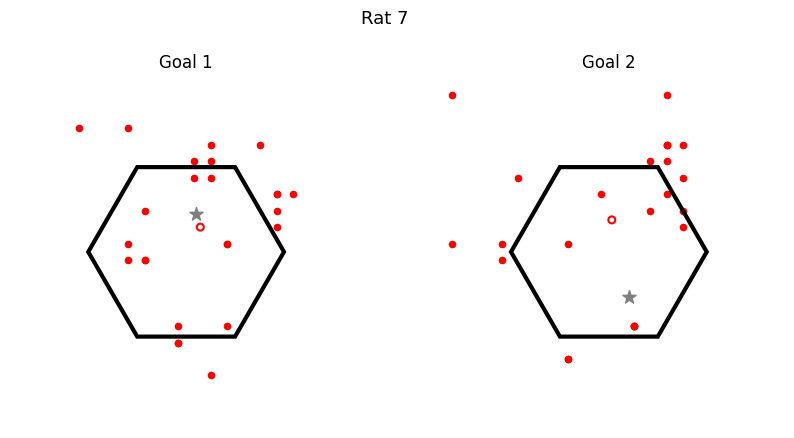

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for j, sink in enumerate(Best_Sinks_activeScan_goal1):
    ax[0].scatter(sink[0], sink[1], color="red", s=20, marker='o')
ax[0].scatter(goal_loc_1[0], goal_loc_1[1], c="gray", s=100, marker='*', label="Goal 1")

mean_sink_loc_1 = np.mean(np.vstack(Best_Sinks_activeScan_goal1), axis=0)
ax[0].scatter(mean_sink_loc_1[0], mean_sink_loc_1[1], edgecolors='red', s=25, marker='o', label="Mean Sink 1", facecolors="none", linewidth=1.5)

for j, sink in enumerate(Best_Sinks_activeScan_goal2):
    ax[1].scatter(sink[0], sink[1], color="red", s=20, marker='o')
ax[1].scatter(goal_loc_2[0], goal_loc_2[1], c="gray", s=100, marker='*', label="Goal 2")

mean_sink_loc_2 = np.mean(np.vstack(Best_Sinks_activeScan_goal2), axis=0)
ax[1].scatter(mean_sink_loc_2[0], mean_sink_loc_2[1], edgecolors='red', s=25, marker='o', label="Mean Sink 2", facecolors="none", linewidth=1.5)

hexagon_vertices_and_plot(
    ax[0], 
    center=np.array([0, 0]),
    left_vertex=np.array([-0.5*np.pi, 0]), 
    linewidth=3, 
)
hexagon_vertices_and_plot(
    ax[1], 
    center=np.array([0, 0]),
    left_vertex=np.array([-0.5*np.pi, 0]), 
    linewidth=3, 
)

ax[0].axis("off")
ax[1].axis("off")

ax[0].set_xlim(-.9*np.pi, .9*np.pi)
ax[0].set_ylim(-.9*np.pi, .9*np.pi)
ax[1].set_xlim(-.9*np.pi, .9*np.pi)
ax[1].set_ylim(-.9*np.pi, .9*np.pi)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_title("Goal 1")
ax[1].set_title("Goal 2")

plt.suptitle(f"Rat {rat}", fontsize=13)

plt.savefig(f"figures/consink_locs_real_traj_rat{rat}_goal_switching.pdf", bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [68]:
print(mean_sink_loc_1)
print(mean_sink_loc_2)

[0.22751745 0.39683276]
[0.04761993 0.51323703]


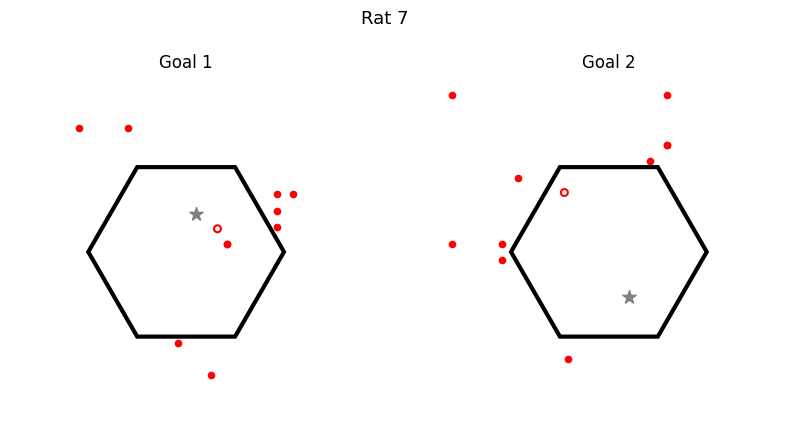

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for j, sink in enumerate(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:10]]):
    ax[0].scatter(sink[0], sink[1], color="red", s=20, marker='o')
ax[0].scatter(goal_loc_1[0], goal_loc_1[1], c="gray", s=100, marker='*', label="Goal 1")

mean_sink_loc_1 = np.mean(np.vstack(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:10]]), axis=0)
ax[0].scatter(mean_sink_loc_1[0], mean_sink_loc_1[1], edgecolor="red", s=25, marker='o', label="Mean Sink 1", facecolors="none", linewidth=1.5)

for j, sink in enumerate(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:10]]):
    ax[1].scatter(sink[0], sink[1], color="red", s=20, marker='o')
ax[1].scatter(goal_loc_2[0], goal_loc_2[1], c="gray", s=100, marker='*', label="Goal 2")

mean_sink_loc_2 = np.mean(np.vstack(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:10]]), axis=0)
ax[1].scatter(mean_sink_loc_2[0], mean_sink_loc_2[1], edgecolor="red", s=25, marker='o', label="Mean Sink 2", facecolors="none", linewidth=1.5)

hexagon_vertices_and_plot(
    ax[0], 
    center=np.array([0, 0]),
    left_vertex=np.array([-0.5*np.pi, 0]), 
    linewidth=3, 
)
hexagon_vertices_and_plot(
    ax[1], 
    center=np.array([0, 0]),
    left_vertex=np.array([-0.5*np.pi, 0]), 
    linewidth=3, 
)

ax[0].axis("off")
ax[1].axis("off")

ax[0].set_xlim(-.9*np.pi, .9*np.pi)
ax[0].set_ylim(-.9*np.pi, .9*np.pi)
ax[1].set_xlim(-.9*np.pi, .9*np.pi)
ax[1].set_ylim(-.9*np.pi, .9*np.pi)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_title("Goal 1")
ax[1].set_title("Goal 2")

plt.suptitle(f"Rat {rat}", fontsize=13)

plt.show()

In [70]:
np.argsort(Best_MRLs_activeScan_goal1)[::-1][:10]

array([20,  4,  9, 14, 19, 24,  3,  8, 13, 15])

0.04285500119724724


0.045947812684073254


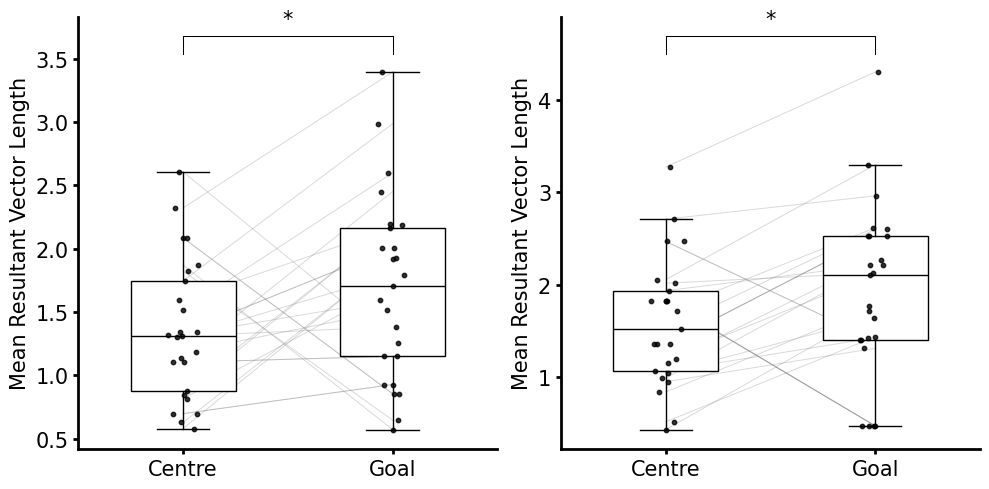

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
top_k = 100
plot_paired_boxplot(
    np.linalg.norm(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:top_k]] - goal_loc_1, axis=1), 
    np.linalg.norm(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:top_k]] - goal_loc_2, axis=1), 
    ax=ax[0], 
    paired_test=True, 
    alternative="less", 
)

plot_paired_boxplot(
    np.linalg.norm(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:top_k]] - goal_loc_1, axis=1), 
    np.linalg.norm(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:top_k]] - goal_loc_2, axis=1), 
    ax=ax[1], 
    paired_test=True, 
    alternative="less", 
)

plt.show()

In [37]:
Best_MRLs_activeScan_goal1[
    np.argsort(Best_MRLs_activeScan_goal1)[::-1][:10]
]

array([0.47237318, 0.46978347, 0.45103483, 0.42775724, 0.38066795,
       0.38044163, 0.35772811, 0.35715384, 0.35679708, 0.33893763])

In [25]:
np.linalg.norm(Best_Sinks_activeScan_goal2 - goal_loc_1, axis=1)

array([1.81160925, 1.50751784, 0.46193056, 0.74437062, 0.72903933,
       1.50751784, 0.46193056, 0.46193056, 0.46193056, 0.92554559,
       1.55251303, 4.34591974, 4.34591974, 1.27352403, 1.10761379,
       2.85199214, 3.96921549, 2.50501009, 3.59023114, 2.16615556,
       3.30934652, 3.96921549, 2.79632394, 3.37773074, 2.28632105])

In [26]:
np.linalg.norm(Best_Sinks_activeScan_goal2 - goal_loc_2, axis=1)

array([1.94409782, 1.35695718, 1.43727086, 1.61845984, 1.9792985 ,
       1.35695718, 1.43727086, 1.43727086, 1.43727086, 1.26536938,
       1.10866185, 2.56953782, 2.56953782, 2.01968368, 1.76441373,
       2.02438569, 3.78384608, 4.19356618, 3.12087256, 2.03713897,
       3.59376676, 3.78384608, 4.54203986, 1.92142161, 2.2925707 ])

0.7910486541812052
1.2623089851574535e-07
0.8712173655074148
0.0031080562557459328


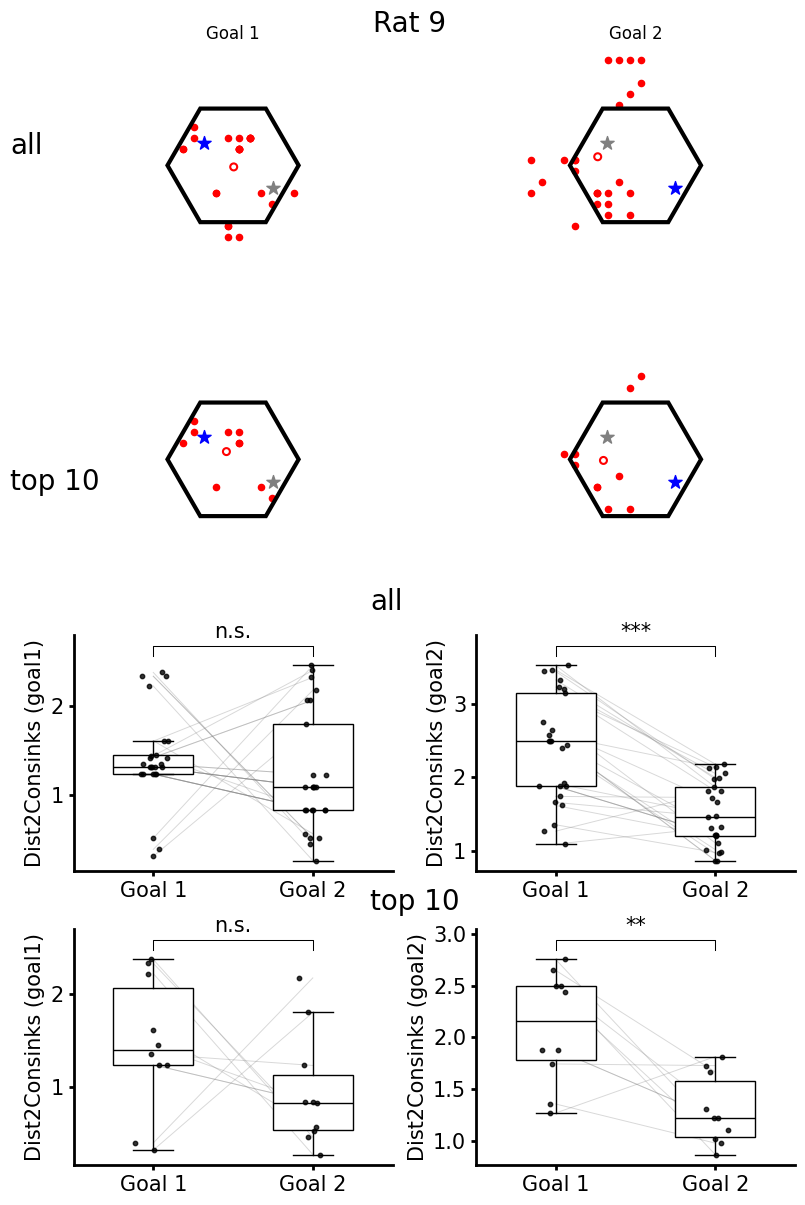

In [111]:
rat = 9
session = rat_session_2[rat]

(Best_Sinks_activeScan_goal1, Best_MRLs_activeScan_goal1) = pickle.load(
    open("logs/ConSink_real_traj_rat_"+str(rat)+"_switching_goal_goal1.pkl", "rb")
)

Best_Sinks_activeScan_goal1 = np.array(Best_Sinks_activeScan_goal1)
Best_MRLs_activeScan_goal1 = np.array(Best_MRLs_activeScan_goal1)

(Best_Sinks_activeScan_goal2, Best_MRLs_activeScan_goal2) = pickle.load(
    open("logs/ConSink_real_traj_rat_"+str(rat)+"_switching_goal_goal2.pkl", "rb")
)
Best_Sinks_activeScan_goal2 = np.array(Best_Sinks_activeScan_goal2)
Best_MRLs_activeScan_goal2 = np.array(Best_MRLs_activeScan_goal2)

pos_mat_logdir = os.path.join(BASEDIR, f"Rat{rat}", session, "positionalData", "positionalDataByTrialType.mat")
running_gaps_logdir = os.path.join(BASEDIR, f"Rat{rat}", session, "physiologyData", "runningGaps.mat")

d_behavioural_data = get_behavioural_data_goal_switching(
    pos_mat_logdir, 
    running_gaps_logdir,
)

goal_loc_1 = d_behavioural_data["goal1"]["goal_location"]
goal_loc_2 = d_behavioural_data["goal2"]["goal_location"]

fig, ax = plt.subplots(4, 2, figsize=(8, 12))

for j, sink in enumerate(Best_Sinks_activeScan_goal1):
    ax[0, 0].scatter(sink[0], sink[1], color="red", s=20, marker='o')
ax[0, 0].scatter(goal_loc_1[0], goal_loc_1[1], c="gray", s=100, marker='*', label="Goal 1")
ax[0, 0].scatter(goal_loc_2[0], goal_loc_2[1], c="b", s=100, marker='*', label="Goal 2")

mean_sink_loc_1 = np.mean(np.vstack(Best_Sinks_activeScan_goal1), axis=0)
ax[0, 0].scatter(mean_sink_loc_1[0], mean_sink_loc_1[1], edgecolors='red', s=25, marker='o', label="Mean Sink 1", facecolors="none", linewidth=1.5)

for j, sink in enumerate(Best_Sinks_activeScan_goal2):
    ax[0, 1].scatter(sink[0], sink[1], color="red", s=20, marker='o')
ax[0, 1].scatter(goal_loc_2[0], goal_loc_2[1], c="gray", s=100, marker='*', label="Goal 2")
ax[0, 1].scatter(goal_loc_1[0], goal_loc_1[1], c="b", s=100, marker='*', label="Goal 2")

mean_sink_loc_2 = np.mean(np.vstack(Best_Sinks_activeScan_goal2), axis=0)
ax[0, 1].scatter(mean_sink_loc_2[0], mean_sink_loc_2[1], edgecolors='red', s=25, marker='o', label="Mean Sink 2", facecolors="none", linewidth=1.5)

hexagon_vertices_and_plot(
    ax[0, 0], 
    center=np.array([0, 0]),
    left_vertex=np.array([-0.5*np.pi, 0]), 
    linewidth=3, 
)
hexagon_vertices_and_plot(
    ax[0, 1], 
    center=np.array([0, 0]),
    left_vertex=np.array([-0.5*np.pi, 0]), 
    linewidth=3, 
)

ax[0, 0].axis("off")
ax[0, 1].axis("off")

ax[0, 0].set_xlim(-.9*np.pi, .9*np.pi)
ax[0, 0].set_ylim(-.9*np.pi, .9*np.pi)
ax[0, 1].set_xlim(-.9*np.pi, .9*np.pi)
ax[0, 1].set_ylim(-.9*np.pi, .9*np.pi)

ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')

ax[0, 0].set_title("Goal 1")
ax[0, 1].set_title("Goal 2")

for j, sink in enumerate(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:10]]):
    ax[1, 0].scatter(sink[0], sink[1], color="red", s=20, marker='o')
ax[1, 0].scatter(goal_loc_1[0], goal_loc_1[1], c="gray", s=100, marker='*', label="Goal 1")
ax[1, 0].scatter(goal_loc_2[0], goal_loc_2[1], c="b", s=100, marker='*', label="Goal 2")

mean_sink_loc_1 = np.mean(np.vstack(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:10]]), axis=0)
ax[1, 0].scatter(mean_sink_loc_1[0], mean_sink_loc_1[1], edgecolor="red", s=25, marker='o', label="Mean Sink 1", facecolors="none", linewidth=1.5)

for j, sink in enumerate(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:10]]):
    ax[1, 1].scatter(sink[0], sink[1], color="red", s=20, marker='o')
ax[1, 1].scatter(goal_loc_2[0], goal_loc_2[1], c="gray", s=100, marker='*', label="Goal 2")
ax[1, 1].scatter(goal_loc_1[0], goal_loc_1[1], c="b", s=100, marker='*', label="Goal 2")

mean_sink_loc_2 = np.mean(np.vstack(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:10]]), axis=0)
ax[1, 1].scatter(mean_sink_loc_2[0], mean_sink_loc_2[1], edgecolor="red", s=25, marker='o', label="Mean Sink 2", facecolors="none", linewidth=1.5)

hexagon_vertices_and_plot(
    ax[1, 0], 
    center=np.array([0, 0]),
    left_vertex=np.array([-0.5*np.pi, 0]), 
    linewidth=3, 
)
hexagon_vertices_and_plot(
    ax[1, 1], 
    center=np.array([0, 0]),
    left_vertex=np.array([-0.5*np.pi, 0]), 
    linewidth=3, 
)

ax[1, 0].axis("off")
ax[1, 1].axis("off")

ax[1, 0].set_xlim(-.9*np.pi, .9*np.pi)
ax[1, 0].set_ylim(-.9*np.pi, .9*np.pi)
ax[1, 1].set_xlim(-.9*np.pi, .9*np.pi)
ax[1, 1].set_ylim(-.9*np.pi, .9*np.pi)

ax[1, 0].set_aspect('equal')
ax[1, 1].set_aspect('equal')

top_k = 100
plot_paired_boxplot(
    np.linalg.norm(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:top_k]] - goal_loc_1, axis=1), 
    np.linalg.norm(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:top_k]] - goal_loc_2, axis=1), 
    ax=ax[2, 0], 
    paired_test=True, 
    alternative="less", 
    labels=["Goal 1", "Goal 2"], 
    ylabel="Dist2Consinks (goal1)",
)

plot_paired_boxplot(
    np.linalg.norm(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:top_k]] - goal_loc_1, axis=1), 
    np.linalg.norm(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:top_k]] - goal_loc_2, axis=1), 
    ax=ax[2, 1], 
    paired_test=True, 
    alternative="greater", 
    labels=["Goal 1", "Goal 2"], 
    ylabel="Dist2Consinks (goal2)",
)

top_k = 10
plot_paired_boxplot(
    np.linalg.norm(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:top_k]] - goal_loc_1, axis=1), 
    np.linalg.norm(Best_Sinks_activeScan_goal1[np.argsort(Best_MRLs_activeScan_goal1)[::-1][:top_k]] - goal_loc_2, axis=1), 
    ax=ax[3, 0], 
    paired_test=True, 
    alternative="less", 
    labels=["Goal 1", "Goal 2"], 
    ylabel="Dist2Consinks (goal1)",
)

plot_paired_boxplot(
    np.linalg.norm(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:top_k]] - goal_loc_1, axis=1), 
    np.linalg.norm(Best_Sinks_activeScan_goal2[np.argsort(Best_MRLs_activeScan_goal2)[::-1][:top_k]] - goal_loc_2, axis=1), 
    ax=ax[3, 1], 
    paired_test=True, 
    alternative="greater", 
    labels=["Goal 1", "Goal 2"], 
    ylabel="Dist2Consinks (goal2)",
)

fontsize = 20

plt.suptitle(f"Rat {rat}", fontsize=fontsize, y=1.0)

fig.text(0.0, 0.88, "all", fontsize=fontsize)
fig.text(0.0, 0.6, "top 10", fontsize=fontsize)
fig.text(0.45, 0.5, "all", fontsize=fontsize)
fig.text(0.45, 0.25, "top 10", fontsize=fontsize)

plt.savefig(f"figures/consink_locs_real_traj_rat{rat}_goal_switching.pdf", bbox_inches='tight', dpi=300, transparent=True)

plt.show()